# Assignment 6: Matrix as a Linear Transformation
## DTSC 680: Applied Machine Learning

## Name: Betty Tai


The purpose of this assignment is to use the KNeighborsClassifier to use the KNNimputer class. 
We 
1. create a feature matrix with a categorical features, 
2. create a feature matrix with missing values in the categorical feature, 
3. Train KNN learner using fit with the last two columns and with the first column becoming a row vector on the data, 
4. Predict the class of missing values using the predict method, 
5. Join a column of predicted class with their other features using numpy's hstack
6. Join the two features using vstack. 


In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



In [3]:
file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'

def reset_display(): 
  pd.reset_option("^display")

def max_rows(integer): 
  pd.set_option("display.max_rows", integer)

def data_refresh(file): 
  data = pd.read_csv(file, 
                      header=None, na_values='?')
  data.columns=['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
          'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
          'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
          'stalk-surface-below-ring', 'stalk-color-above-ring',
          'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
          'ring-type', 'spore-print-color', 'population', 'habitat']
  return data

def nan_check(data): 
  print("Is there any NaN in this data?")
  print(data.isnull().any())
  nan_label=data.columns[data.isna().any()].tolist()
  print(len(nan_label))
  for i in range(len(nan_label)):
    print(i)
    print("What is unique value? {a} {b}".format(a=nan_label[i], b=data[nan_label[i]].unique()))
    m = data[nan_label[i]].isnull().sum()
    print('Number of NaN missing values by category', m)
  return nan_label
reset_display()
data = data_refresh(file)

nan_check(data)



Is there any NaN in this data?
class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                   True
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool
1
0
What is unique value? stalk-root ['e' 'c' 'b' 'r' nan]
Number of NaN missing values by category 2480


['stalk-root']

## Load the data
Here we load the data. 

In [4]:
target = "ring-number"
nan_label = nan_check(data)
for i in range(len(nan_label)):
  x = data.drop(columns=[target, nan_label[i]])
  y = data[target]

print("Full Data set shape is",data.shape)
print("Shape of data and labels is",x.shape,y.shape)

Is there any NaN in this data?
class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                   True
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool
1
0
What is unique value? stalk-root ['e' 'c' 'b' 'r' nan]
Number of NaN missing values by category 2480
Full Data set shape is (8124, 23)
Shape of data and labels is (8124, 2

## OneHotEncode all data to select for best features 
Use onehotencoding for feature data and use ordinal encode for response data varible ring-number because all columns are categorical values. 
We then check it as well as shown bottom and we also do not include the feature that has nan which is the 'stalk-root'. 

In [5]:
hot_x = pd.get_dummies(x) #onehotencoding
hot_y = pd.get_dummies(y)
hot_df = pd.get_dummies(data)

### Feature Selection: Part 1

Here we look at the chi-squared to see which features have the strongest relationship. 
Odor looks pretty good. 

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

kbest = SelectKBest(score_func=chi2, k=10)
fit = kbest.fit(hot_x,hot_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(hot_x.columns)
#concat two dataframes for better visualization 
featscores = pd.concat([dfcolumns,dfscores],axis=1)
featscores.columns = ['Mushroom Attributes','Relationship Score']  #naming the dataframe columns
print(featscores.nlargest(5,'Relationship Score'))  #print 10 best features

          Mushroom Attributes  Relationship Score
28                     odor_m             8088.00
62   stalk-color-above-ring_c             8088.00
71   stalk-color-below-ring_c             8088.00
87                ring-type_n             8088.00
110                 habitat_w             2407.68


### Feature Selection: Part 2

When we plot the score of feature importance, the higher the score, the more important or relevant it is towards the dependent variable. 
With the use of feature importances of the library for ETC (Extra Tree Classifier), ETC will be used for extracting the best 10. 

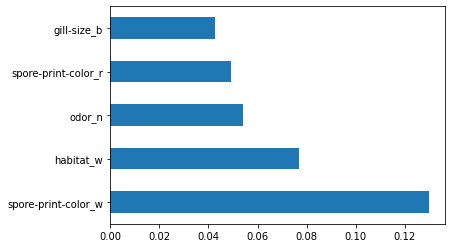

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(hot_x, hot_y)

#now to visualize it
feat_importances = pd.Series(model.feature_importances_, index=hot_x.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()



Spore-Print-Color looks pretty good. 

### Feature Selection: Part 3
We use correlation to see how the features are related with either each other or the target variable. 
It can be either positive or negative with respect to the target variable. 
A heatmap can make it simple to find which features are most correlated with the target varible. 
Plotted heatmap is shown below. 

1 Label Encoded class are [1 0]
2 Label Encoded cap-shape are [5 0 4 2 3 1]
3 Label Encoded cap-surface are [2 3 0 1]
4 Label Encoded cap-color are [4 9 8 3 2 5 0 7 1 6]
5 Label Encoded bruises are [1 0]
6 Label Encoded odor are [6 0 3 5 2 1 8 7 4]
7 Label Encoded gill-attachment are [1 0]
8 Label Encoded gill-spacing are [0 1]
9 Label Encoded gill-size are [1 0]
10 Label Encoded gill-color are [ 4  5  2  7 10  3  9  1  0  8 11  6]
11 Label Encoded stalk-shape are [0 1]
12 Label Encoded stalk-surface-above-ring are [2 0 1 3]
13 Label Encoded stalk-surface-below-ring are [2 0 3 1]
14 Label Encoded stalk-color-above-ring are [7 3 6 4 0 2 5 1 8]
15 Label Encoded stalk-color-below-ring are [7 6 3 0 4 2 8 5 1]
16 Label Encoded veil-type are [0]
17 Label Encoded veil-color are [2 0 1 3]
18 Label Encoded ring-number are [1 2 0]
19 Label Encoded ring-type are [4 0 2 1 3]
20 Label Encoded spore-print-color are [2 3 6 1 7 5 4 8 0]
21 Label Encoded population are [3 2 0 4 5 1]
22 Label Encoded ha

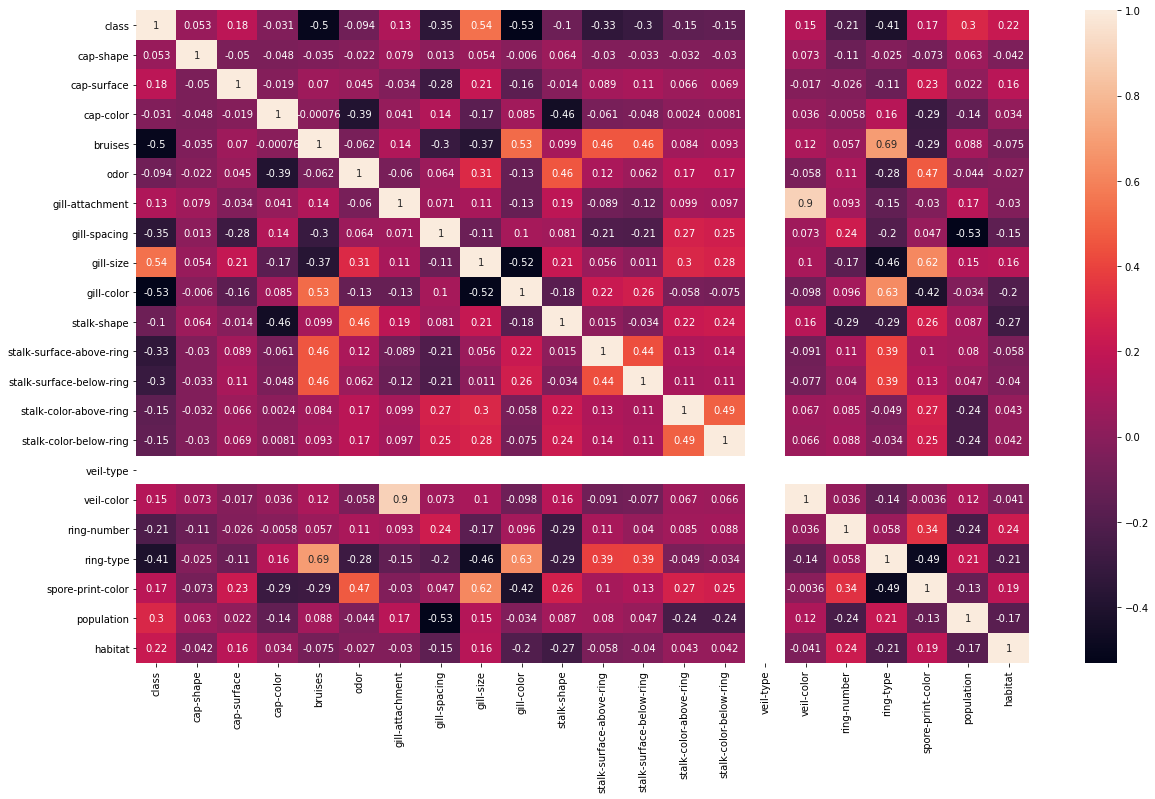

In [8]:
import seaborn as sns
# Encoding the categorical values to numerical values.
le = LabelEncoder()
for i in range(len(nan_label)): 
  data_nonan = data.drop(columns=[nan_label[i]])

dlist=data_nonan.columns.values

for i in range(len(dlist)): # this loop will encode values in the features of the dataset one by one 
    data_nonan[dlist[i]] = le.fit_transform(data[dlist[i]])
    print("{a} Label Encoded {b} are {c}".format(a=(i + 1),b=(dlist[i]), c=data_nonan[dlist[i]].unique())) 
    

#get correlations of each features in dataset
cor_mat = data_nonan.corr()
plt.figure(figsize = (20, 12)) 
print(data_nonan.shape)
sns.heatmap(cor_mat, annot = True)



Clearly veil-type is not useful as it shows little to no variance. We want something to have high variance so that can represent the data accurately but at a potential cost of overfitting. 

Gill-color has 0.096 correlation, which is pretty good. 

So we'll choose: 
1. odor
2. gill-color

## Encode the response and feature data
Use onehotencoding for feature data and use ordinal encode for response data

In [9]:
pip install category-encoders

     |████████████████████████████████| 80 kB 3.9 MB/s 


In [10]:
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
#from category_encoders import *

ringnumber=['n', 'o', 't']
target = "ring-number"
encode_mapping={'n':0,'o':1,'t':2}
x_data = data[["odor", "gill-color"]]
response = data[[target]]
x = pd.get_dummies(x_data) # One-Hot Encoding for attributes. 
#print(y)

def inverse_map(my_map): 
  inv_map = {v: k for k, v in my_map.items()}
  return inv_map

def ord_enc(column_name, mapping, orig_data):
  isinstance(column_name, str)
  isinstance(mapping, dict)
  isinstance(orig_data, type(data))
  y = orig_data[[column_name]]
  print(y)
  ord_encoder = ce.OrdinalEncoder(cols=[column_name],
                                    return_df=True,
                                    mapping=[{'col':column_name,
                                          'mapping':mapping}])
  return ord_encoder.fit_transform(y)

# undummify taken from: 
#https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas/62085741#62085741
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df 



#print(isinstance(data, type(data)))

y = ord_enc(target,encode_mapping,data)


#print(type(y))
#print(type(x))
print("response variable after ordinal encoding transformation:")
print(y)

print(x.shape)
print(y.shape)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     ring-number
0              o
1              o
2              o
3              o
4              o
...          ...
8119           o
8120           o
8121           o
8122           o
8123           o

[8124 rows x 1 columns]
response variable after ordinal encoding transformation:
      ring-number
0               1
1               1
2               1
3               1
4               1
...           ...
8119            1
8120            1
8121            1
8122            1
8123            1

[8124 rows x 1 columns]
(8124, 21)
(8124, 1)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [11]:

missing = data[nan_label]
#print(nan_data)
#join left and right by vertical axis. 
data_new = pd.concat([x,y, missing], axis=1)
print(data_new.shape)
#print(data_new.isnull().sum())

XY_train = data_new.dropna()
#print(XY_train.isnull().sum())
XY_test_nan = data_new[~data_new.index.isin(XY_train.index)]
#X_test = XY_train_nan[]
#print(XY_train_nan.isnull().sum())
print(XY_train.shape)
print(XY_test_nan.shape)
#print(XY_train_nan)
print(missing)


(8124, 23)
(5644, 23)
(2480, 23)
     stalk-root
0             e
1             c
2             c
3             e
4             e
...         ...
8119        NaN
8120        NaN
8121        NaN
8122        NaN
8123        NaN

[8124 rows x 1 columns]


In [12]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
X_train = XY_train.iloc[:,0:21]
#print(X_train)
y_train = XY_train.iloc[:,21:22]
print(y_train)
X_test = XY_test_nan.iloc[:,0:21]
#print(X_test)
y_test = XY_test_nan.iloc[:,21:22]
#print(y_test)
print("Shape of X_train, y_train is ",X_train.shape,y_train.shape)
print("Shape of X_test, y_test is ",X_test.shape,y_test.shape)
print("test_train_split by hand's test size is ",(y_test.shape[0]/data_new.shape[0])*100, "%")
#y_test
knn_clf.fit(X_train, y_train)
imputed_values = pd.DataFrame(knn_clf.predict(X_test), index=X_test.index, columns=['stalk-root'])
#for i in range(len(nan_label)): 
#  imputed_values.columns=[[nan_label[i]]]
#imputed_values.columns=[['stalk-root']]

print(type(imputed_values))
print(imputed_values)



      ring-number
0               1
1               1
2               1
3               1
4               1
...           ...
7986            2
8001            2
8038            2
8095            0
8114            0

[5644 rows x 1 columns]
Shape of X_train, y_train is  (5644, 21) (5644, 1)
Shape of X_test, y_test is  (2480, 21) (2480, 1)
test_train_split by hand's test size is  30.526834071885773 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


<class 'pandas.core.frame.DataFrame'>
      stalk-root
3984           1
4023           1
4076           1
4100           1
4104           1
...          ...
8119           1
8120           1
8121           1
8122           1
8123           1

[2480 rows x 1 columns]


Now joining the imputed values with the X_test(the rows that contained the stalk-root's NAN's used to predict the imputed values; now they are being used to replace the NAN's. 

In [13]:
#imputed_set = pd.concat([response, imputed_values], axis=1, sort=False).sort_index()
data = data_refresh(file)
nan_check(data)
data_copy=data.copy()
data_copy.update(imputed_values)
nan_check(data_copy)
imputed_set = pd.concat([response, imputed_values], axis=1)
print("combining imputed values through KneighborsClassification: ")

Is there any NaN in this data?
class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                   True
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool
1
0
What is unique value? stalk-root ['e' 'c' 'b' 'r' nan]
Number of NaN missing values by category 2480
Is there any NaN in this data?
class                       False
cap-s

Now we merge the final data set to the onehot encoded feature data with the ordinally encoded response data as well as the column with imputed values. 

### Converting the variable missing_value and printing first 10
Here we convert the variable missing_value to a list and then sort it by index and then print the first 10 elements in the list. 

In [14]:
missing_values = imputed_values.copy()
missing_values = np.sort(missing_values).tolist()
print("data structure of {}".format(missing_values), type(missing_values))
print("first ten elements of in order of increasing index {}".format('missing_values list'), missing_values[0:9])
print("first ten indices of  {}".format('imputed_values dataframe'), imputed_values.head(10).index.tolist())
print("first ten elements of in order of increasing index {}".format('imputed_values dataframe'), imputed_values.head(10).values.tolist())

data structure of [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [

####Graded Concept Question (include a section in your notebook): 
Would it still be possible to train the KNN model if you one-hot encoded the response data instead? Why or why not?

**Answer**
<p>
Yes it would be possible. No, it is not a good idea because KNN is based on Euclidean distances, and it would be unable to give weight to what matters in ordinal data such as "0,1,2" in the response data (ring-number) I used. The response data would need to be scaled correctly in order to compute Euclidean mean right. One hot encoding is best for categorical features, but if it is used on ordinal data such as what I used, it is not good because it introduces multicollinearity and doesn't reflect that 0 is less than 1, which is also less than 2, and that 1 is less than 2 unless it is specified. 

## RandomForestClassifier and Logistic Regression





In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import timeit

target='class'
x_data = data_copy.drop(labels=[target], axis=1)
y = ord_enc(target,{'e':0, 'p':1},data_copy)
X = pd.get_dummies(x_data, drop_first=True) # One-Hot Encoding for attributes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def classifier(model, X_train, y_train, X_test, y_test, target, name): 
  starttime = timeit.default_timer()
  clf = model(random_state=42)
  clf.fit(X_train, y_train)
  y_pred = pd.DataFrame(clf.predict(X_test), index=y_test.index, columns=[target])
  t = timeit.default_timer() - starttime
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  arr1 = []
  arr2 = []
  arr3 = []
  arr4 = []
  Accuracy= "Accuracy"
  Precision = "Precision"
  Recall = "Recall"
  Time = "Time" 
  arr1.append(name)
  arr1.append(Accuracy)
  arr1.append(acc)
  arr2.append(name)
  arr2.append(Precision)
  arr2.append(prec)
  arr3.append(name)
  arr3.append(Recall)
  arr3.append(rec)
  arr4.append(name)
  arr4.append(Time)
  arr4.append(t)
  arr=[arr1,arr2,arr3,arr4]
  np.array(arr)
  return arr

rfc=[]
rfc = classifier(RandomForestClassifier, X_train, y_train, X_test, y_test, target, "Random Forest")
print(rfc)
lr=[]
lr = classifier(LogisticRegression, X_train, y_train, X_test, y_test, target, "Logistic Regression")
print(lr)


     class
0        p
1        e
2        e
3        p
4        e
...    ...
8119     e
8120     e
8121     e
8122     p
8123     e

[8124 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[['Random Forest', 'Accuracy', 1.0], ['Random Forest', 'Precision', 1.0], ['Random Forest', 'Recall', 1.0], ['Random Forest', 'Time', 0.4015632689999791]]
[['Logistic Regression', 'Accuracy', 0.9995898277276456], ['Logistic Regression', 'Precision', 1.0], ['Logistic Regression', 'Recall', 0.9991423670668954], ['Logistic Regression', 'Time', 0.13000774899998646]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Graded Concept Question (include a section in your notebook): Would it still be possible to train these two models if you one-hot encoded the response data instead, being careful to specify that the drop parameter of the OneHotEncoder class is set to ‘first’? Why or why not?


Yes it is fine to do because it is a categorical variable and does not intrinsically have an order or weight to it. 

### accuracy, precision, and recall scores



In [17]:
columns=["Models", "Item", "Full Data"]
#Item=["Accuracy", "Precision", "Recall", "Time"]
FullData=np.concatenate([rfc,lr])
print(FullData.shape)
print(np.shape([rfc[0], rfc[1], rfc[2]]))

#pd.DataFrame(data=[rfc[0], rfc[1], rfc[2]], columns=columns)
fulldf=pd.DataFrame(data=FullData, columns=columns)
fulldf

(8, 3)
(3, 3)


,Models,Item,Full Data
0,Random Forest,Accuracy,1.0
1,Random Forest,Precision,1.0
2,Random Forest,Recall,1.0
3,Random Forest,Time,0.4015632689999791
4,Logistic Regression,Accuracy,0.9995898277276456
5,Logistic Regression,Precision,1.0
6,Logistic Regression,Recall,0.9991423670668954
7,Logistic Regression,Time,0.13000774899998646


## PCA

Perform dimensionality reduction using PCA and keep 95% of the variance. By what percentage were you able to reduce the number of dimensions of the training set? How many features (i.e. dimensions) are you left with after reducing dimensionality?

In [18]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
print(X_train)
X_train_pca = pca.fit(X_train)
print(pca.n_components_, "features left")

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


      cap-shape_c  cap-shape_f  cap-shape_k  ...  habitat_p  habitat_u  habitat_w
5314            0            0            0  ...          0          0          0
2075            0            0            0  ...          0          0          0
5165            0            1            0  ...          0          0          0
1155            0            0            0  ...          0          0          0
4448            0            0            0  ...          0          0          0
...           ...          ...          ...  ...        ...        ...        ...
4931            0            0            0  ...          0          0          1
3264            0            0            0  ...          1          0          0
1653            0            0            0  ...          0          0          0
2607            0            1            0  ...          0          0          0
2732            0            0            0  ...          0          0          0

[5686 rows x 95

38 features were left (because we onehot encoded the features). 

## PCA + RandomForestClassifier and Logistic Regression

In [19]:
rfc_pca=[]
rfc_pca = classifier(RandomForestClassifier, X_train_pca, y_train, X_test_pca, y_test, target, "Random Forest")
print(rfc_pca)
lr_pca=[]
lr_pca = classifier(LogisticRegression, X_train_pca, y_train, X_test_pca, y_test, target, "Logistic Regression")
print(lr_pca)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[['Random Forest', 'Accuracy', 1.0], ['Random Forest', 'Precision', 1.0], ['Random Forest', 'Recall', 1.0], ['Random Forest', 'Time', 2.3668140419999872]]
[['Logistic Regression', 'Accuracy', 0.9934372436423298], ['Logistic Regression', 'Precision', 0.9939862542955327], ['Logistic Regression', 'Recall', 0.9922813036020584], ['Logistic Regression', 'Time', 0.05658525999999142]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Compute the accuracy, precision, and recall scores for the model trained on the reduced data set using the same test set as before. 

What conclusions can you make about these models and the PCA process? How do the models compare? Discuss the trends observed for model training time and performance for the full and reduced data sets. Tabulate the following information in your final analysis:




In [21]:
columns=["Models", "Item", "PCA Reduced"]
#Item=["Accuracy", "Precision", "Recall", "Time"]
print(np.shape(rfc_pca))
PCAData=np.concatenate([rfc_pca, lr_pca])
pcadf=pd.DataFrame(data=PCAData, columns=columns)
print(pcadf)

def bold_values(val):
  if val == "Random Forest": 
    bold = 'bold' 
  elif val == "Logistic Regression": 
    bold = 'bold'
  else: 
    pass
  return 'font-weight: %s' % bold


merged = fulldf.merge(pcadf, how='right', on=['Models', 'Item'])
merged.style.apply(bold_values)
merged

(4, 3)
                Models       Item          PCA Reduced
0        Random Forest   Accuracy                  1.0
1        Random Forest  Precision                  1.0
2        Random Forest     Recall                  1.0
3        Random Forest       Time   2.3668140419999872
4  Logistic Regression   Accuracy   0.9934372436423298
5  Logistic Regression  Precision   0.9939862542955327
6  Logistic Regression     Recall   0.9922813036020584
7  Logistic Regression       Time  0.05658525999999142


,Models,Item,Full Data,PCA Reduced
0,Random Forest,Accuracy,1.0,1.0
1,Random Forest,Precision,1.0,1.0
2,Random Forest,Recall,1.0,1.0
3,Random Forest,Time,0.4015632689999791,2.3668140419999872
4,Logistic Regression,Accuracy,0.9995898277276456,0.9934372436423298
5,Logistic Regression,Precision,1.0,0.9939862542955327
6,Logistic Regression,Recall,0.9991423670668954,0.9922813036020584
7,Logistic Regression,Time,0.13000774899998646,0.05658525999999142


**Answer**



What conclusions can you make about these models and the PCA process? How do the models compare? Discuss the trends observed for model training time and performance for the full and reduced data sets. 

**Answer**
PCA helps reduce dimensionaltiy in the data set but at a cost of increasing time for the RandomForestRegressor but decreasing the time needed for Logistic Regression. PCA is meant to create new uncorrelated variables and increase variance.
For Logistic Regression, precision has decreased but minimally so. GridSearchCV would probably help tune the hyperparameters and elucidate how much a help PCA would be. If we had a dataset with a lot of multicollinearity in independent variables, PCA would be the most applicable. 